In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

## 1. SoftMax

### 1.1 效果示例

softmax 能把输出值转换成对应概率，output的所有entry相加的最终值为1

即 T = 1 

In [4]:
logits = np.array([-1,2,3,6])

In [5]:
softmax_1 = np.exp(logits)/sum(np.exp(logits))

In [6]:
softmax_1

array([8.53011713e-04, 1.71331982e-02, 4.65728615e-02, 9.35440929e-01])

In [7]:
total = 0
for i in softmax_1:
    total += i
print(total)

1.0


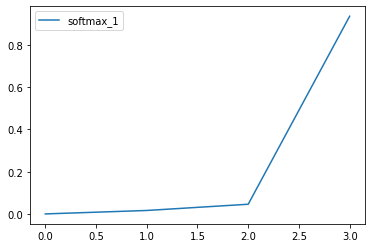

In [8]:
plt.plot(softmax_1,label="softmax_1")
plt.legend()
plt.show()

### 1.2 不同温度对应的softmax效果

可以观察到，温度越大各个种类的输出结果趋于平均。

In [9]:
def distill_softmax(logits,temperature):
    output = np.exp(logits/temperature)/sum(np.exp(logits/temperature))
    return output

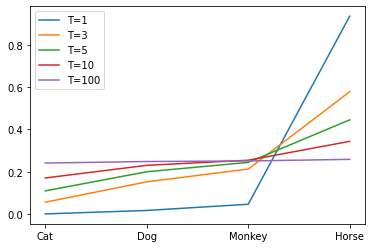

In [10]:
plt.plot(softmax_1, label='T=1')

softmax_3 = distill_softmax(logits,3)
plt.plot(softmax_3, label='T=3')

softmax_5 = distill_softmax(logits,5)
plt.plot(softmax_5, label='T=5')

softmax_10 = distill_softmax(logits,10)
plt.plot(softmax_10, label='T=10')

softmax_100 = distill_softmax(logits,100)
plt.plot(softmax_100, label='T=100')


plt.xticks(np.arange(4),['Cat','Dog','Monkey','Horse'])
plt.legend()
plt.show()

## 2. 训练模型

### 2.1 从零训练resnet18 

In [11]:
#Resnet18
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time


# 超参数定义
EPOCH = 25              # 训练epoch次数
BATCH_SIZE = 1024        # 批训练的数量
resnet18_train_losses = []
resnet18_train_acces = []
# 用数组保存每一轮迭代中，在测试数据上测试的损失值和精确度，也是为了通过画图展示出来。
resnet18_eval_losses = []
resnet18_eval_acces = []

# MNIST数据集下载
train_data = datasets.CIFAR10(root='./data',
                         train=True,                         # 训练集
                         transform=transforms.ToTensor(),    # 转换为Tensor并归一化[0~1]
                         download=True
                        )

test_data = datasets.CIFAR10(root='./data',
                        train=False,                         # 测试集
                        transform=transforms.ToTensor(),     # 转换为Tensor并归一化[0~1]
                        download=True
                        )
# Cifar-10的标签
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# 使用DataLoader进行分批  dataset: 传入的数据集 batch_size: 每个batch有多少个样本  shuffle: 在每个epoch开始的时候，对数据进行重新排序
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

# ResNet Model
model = torchvision.models.resnet18(pretrained=False) # 使用resnet18模型

#损失函数:这里用交叉熵 = log_softmax和nll_loss的结合
criterion = nn.CrossEntropyLoss()
#优化器 这里用SGD
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#device : GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) #将模型加载到相应设备中
Total_acc = 0


# 开始训练
for epoch in range(EPOCH):
    start_time = time.time() #记录当前时间
    train_loss = 0
    train_acc = 0
    model.train()
    for i, data in enumerate(train_loader, start=0):
        # data里面包含图像数据（inputs）(tensor类型的）和标签（labels）(tensor类型）。
        inputs, labels = data
        # 将数据加载到相应设备中
        inputs, labels = inputs.to(device), labels.to(device)
        # 前向传播
        outputs = model(inputs)
        # 计算损失函数
        loss = criterion(outputs, labels)
        # 清空上一轮梯度
        optimizer.zero_grad()
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()
        train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        num_correct = (predicted == labels).sum().item()
        acc = num_correct / inputs.shape[0]
        train_acc += acc

    resnet18_train_losses.append(train_loss / len(train_loader))
    resnet18_train_acces.append(train_acc / len(train_loader))

    model.eval() #切换到测试模式
    eval_loss = 0
    eval_acc = 0
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # 前向传播
        out = model(images)
        loss = criterion(out, labels)
        eval_loss += loss.item()
        # 求出预测值索引  torch.max(input, dim) dim=1，行最大值
        _, predicted = torch.max(out.data, 1)
        num_correct = (predicted == labels).sum().item()
        acc = num_correct / images.shape[0]
        eval_acc += acc
    
    resnet18_eval_losses.append(eval_loss/len(test_loader))
    resnet18_eval_acces.append((eval_acc/len(test_loader)))
    if eval_acc > Total_acc:
        torch.save(model, 'cifar10_resnet18.pt')
        print("saved best model")
        Total_acc = eval_acc
    
    print('epoch: {} \nTrain Loss: {:.4f} \nEval Loss: {:.4f} \nTrain Acc: {:.4f} \nEval Acc: {:.4f}'
          .format(epoch, 
                  train_loss / len(train_loader), 
                  eval_loss / len(test_loader), 
                  train_acc / len(train_loader),
                  eval_acc / len(test_loader)))



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


saved best model
epoch: 0 
Train Loss: 3.6563 
Eval Loss: 2.6810 
Train Acc: 0.3097 
Eval Acc: 0.2949
saved best model
epoch: 1 
Train Loss: 1.5453 
Eval Loss: 1.4639 
Train Acc: 0.4977 
Eval Acc: 0.5035
saved best model
epoch: 2 
Train Loss: 1.2305 
Eval Loss: 1.3631 
Train Acc: 0.5776 
Eval Acc: 0.5228
saved best model
epoch: 3 
Train Loss: 1.0231 
Eval Loss: 1.3394 
Train Acc: 0.6510 
Eval Acc: 0.5403
saved best model
epoch: 4 
Train Loss: 0.8221 
Eval Loss: 1.3740 
Train Acc: 0.7256 
Eval Acc: 0.5471
epoch: 5 
Train Loss: 0.6127 
Eval Loss: 1.4931 
Train Acc: 0.8046 
Eval Acc: 0.5290
epoch: 6 
Train Loss: 0.4080 
Eval Loss: 1.5785 
Train Acc: 0.8819 
Eval Acc: 0.5428
epoch: 7 
Train Loss: 0.2336 
Eval Loss: 1.6972 
Train Acc: 0.9438 
Eval Acc: 0.5376
epoch: 8 
Train Loss: 0.1168 
Eval Loss: 1.8387 
Train Acc: 0.9808 
Eval Acc: 0.5416
epoch: 9 
Train Loss: 0.0551 
Eval Loss: 1.9475 
Train Acc: 0.9948 
Eval Acc: 0.5392
epoch: 10 
Train Loss: 0.0265 
Eval Loss: 2.0018 
Train Acc: 0.99

#### 测试resnet18模型

In [12]:
# 测试
model = torch.load('cifar10_resnet18.pt') #加载模型
model.eval() #切换到测试模式

correct = 0
total = 0

for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    # 前向传播
    out = model(images)
    # 求出预测值索引  torch.max(input, dim) dim=1，行最大值
    _, predicted = torch.max(out.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

#输出识别准确率
print('准确率:{:.4f}%'.format(100 * correct / total))

准确率:54.6900%


#### 绘图

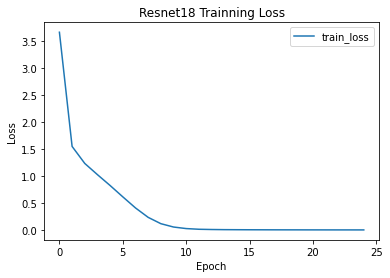

In [53]:
import numpy as np
#%matplotlib inline
plt.plot(np.arange(len(resnet18_train_losses)), resnet18_train_losses, label="train_loss") 
plt.title("Resnet18 Trainning Loss") # 设置标题
plt.xlabel("Epoch") # 设置横轴名称
plt.ylabel("Loss") # 设置纵轴名称
plt.legend() # 图例放置在左下角
plt.savefig("./Resnet18_Trainning_Loss.jpg")

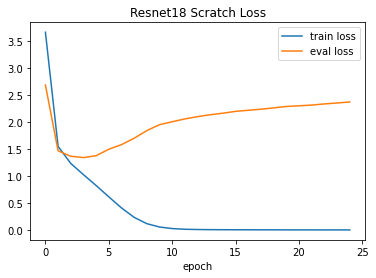

In [65]:
plt.plot(np.arange(len(resnet18_train_losses)), resnet18_train_losses,label="train loss")
plt.plot(np.arange(len(resnet18_eval_losses)), resnet18_eval_losses, label="eval loss")
plt.legend() #显示图例
plt.xlabel('epoch')
plt.title('Resnet18 Scratch Loss')
plt.savefig("./Resnet18_Scratch_Loss.jpg")

In [15]:
resnet18_eval_acces

[0.2949258609693878,
 0.5034538424744899,
 0.5227578922193878,
 0.5403280452806122,
 0.5471161511479592,
 0.5289700255102041,
 0.5427893813775511,
 0.5375837053571428,
 0.541617506377551,
 0.5391960299744898,
 0.5400888871173469,
 0.542562181122449,
 0.5426319355867346,
 0.5430703922193878,
 0.5448022959183674,
 0.5429567920918368,
 0.5450733418367346,
 0.5437599649234695,
 0.5444874043367347,
 0.543311543367347,
 0.544172512755102,
 0.5457928093112245,
 0.5445870535714286,
 0.5437699298469388,
 0.5429508131377551]

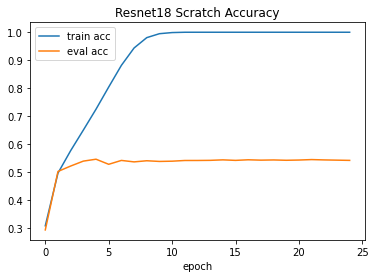

In [66]:
plt.plot(np.arange(len(resnet18_train_acces)), resnet18_train_acces, label="train acc")
plt.plot(np.arange(len(resnet18_eval_acces)), resnet18_eval_acces, label="eval acc")
plt.legend() #显示图例
plt.xlabel('epoch')
plt.title('Resnet18 Scratch Accuracy')
plt.savefig("./Resnet18_Scratch_Accuracy.jpg")

### 2.2 迁移学习resnet50

In [17]:
#Resnet50 with pretrain
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time


# 超参数定义
EPOCH = 25              # 训练epoch次数
BATCH_SIZE = 1024         # 批训练的数量

resnet50_train_losses = []
resnet50_train_acces = []
resnet50_eval_losses = []
resnet50_eval_acces = []

# MNIST数据集下载
train_data = datasets.CIFAR10(root='./data',
                         train=True,                         # 训练集
                         transform=transforms.ToTensor(),    # 转换为Tensor并归一化[0~1]
                         download=True
                        )

test_data = datasets.CIFAR10(root='./data',
                        train=False,                         # 测试集
                        transform=transforms.ToTensor(),     # 转换为Tensor并归一化[0~1]
                        download=True
                        )
# Cifar-10的标签
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# 使用DataLoader进行分批  dataset: 传入的数据集 batch_size: 每个batch有多少个样本  shuffle: 在每个epoch开始的时候，对数据进行重新排序
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

# ResNet Model
model = torchvision.models.resnet50(pretrained=True) # 使用resnet18模型

#损失函数:这里用交叉熵 = log_softmax和nll_loss的结合
criterion = nn.CrossEntropyLoss()
#优化器 这里用SGD
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#device : GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) #将模型加载到相应设备中
Total_acc = 0


# 开始训练
for epoch in range(EPOCH):
    start_time = time.time() #记录当前时间
    train_loss = 0
    train_acc = 0
    model.train()
    for i, data in enumerate(train_loader, start=0):
        # data里面包含图像数据（inputs）(tensor类型的）和标签（labels）(tensor类型）。
        inputs, labels = data
        # 将数据加载到相应设备中
        inputs, labels = inputs.to(device), labels.to(device)
        # 前向传播
        outputs = model(inputs)
        # 计算损失函数
        loss = criterion(outputs, labels)
        # 清空上一轮梯度
        optimizer.zero_grad()
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()
        train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        num_correct = (predicted == labels).sum().item()
        acc = num_correct / inputs.shape[0]
        train_acc += acc

    resnet50_train_losses.append(train_loss / len(train_loader))
    resnet50_train_acces.append(train_acc / len(train_loader))

    model.eval() #切换到测试模式
    eval_loss = 0
    eval_acc = 0
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # 前向传播
        out = model(images)
        loss = criterion(out, labels)
        eval_loss += loss.item()
        # 求出预测值索引  torch.max(input, dim) dim=1，行最大值
        _, predicted = torch.max(out.data, 1)
        num_correct = (predicted == labels).sum().item()
        acc = num_correct / images.shape[0]
        eval_acc += acc
    
    resnet50_eval_losses.append(eval_loss/len(test_loader))
    resnet50_eval_acces.append((eval_acc/len(test_loader)))
    if eval_acc > Total_acc:
        torch.save(model, 'cifar10_resnet50_pretrain.pt')
        print("saved best model")
        Total_acc = eval_acc
    
    print('epoch: {} \nTrain Loss: {:.4f} \nEval Loss: {:.4f} \nTrain Acc: {:.4f} \nEval Acc: {:.4f}'
          .format(epoch, 
                  train_loss / len(train_loader), 
                  eval_loss / len(test_loader), 
                  train_acc / len(train_loader),
                  eval_acc / len(test_loader)))



Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

saved best model
epoch: 0 
Train Loss: 3.4451 
Eval Loss: 1.2777 
Train Acc: 0.3838 
Eval Acc: 0.6172
saved best model
epoch: 1 
Train Loss: 0.8538 
Eval Loss: 0.8495 
Train Acc: 0.7151 
Eval Acc: 0.7207
saved best model
epoch: 2 
Train Loss: 0.5062 
Eval Loss: 0.8261 
Train Acc: 0.8317 
Eval Acc: 0.7397
epoch: 3 
Train Loss: 0.2535 
Eval Loss: 0.9241 
Train Acc: 0.9234 
Eval Acc: 0.7388
epoch: 4 
Train Loss: 0.0931 
Eval Loss: 1.1521 
Train Acc: 0.9758 
Eval Acc: 0.7378
saved best model
epoch: 5 
Train Loss: 0.0388 
Eval Loss: 1.2768 
Train Acc: 0.9917 
Eval Acc: 0.7416
saved best model
epoch: 6 
Train Loss: 0.0186 
Eval Loss: 1.3513 
Train Acc: 0.9963 
Eval Acc: 0.7463
saved best model
epoch: 7 
Train Loss: 0.0102 
Eval Loss: 1.4295 
Train Acc: 0.9981 
Eval Acc: 0.7503
epoch: 8 
Train Loss: 0.0071 
Eval Loss: 1.4926 
Train Acc: 0.9988 
Eval Acc: 0.7490
epoch: 9 
Train Loss: 0.0089 
Eval Loss: 1.4900 
Train Acc: 0.9981 
Eval Acc: 0.7494
epoch: 10 
Train Loss: 0.0056 
Eval Loss: 1.5647

In [ ]:
"""
#Resnet50 without pretrain
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time


# 超参数定义
EPOCH = 25              # 训练epoch次数
BATCH_SIZE = 1024         # 批训练的数量

resnet50_train_losses = []
resnet50_train_acces = []
resnet50_eval_losses = []
resnet50_eval_acces = []

# MNIST数据集下载
train_data = datasets.CIFAR10(root='./data',
                         train=True,                         # 训练集
                         transform=transforms.ToTensor(),    # 转换为Tensor并归一化[0~1]
                         download=True
                        )

test_data = datasets.CIFAR10(root='./data',
                        train=False,                         # 测试集
                        transform=transforms.ToTensor(),     # 转换为Tensor并归一化[0~1]
                        download=True
                        )
# Cifar-10的标签
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# 使用DataLoader进行分批  dataset: 传入的数据集 batch_size: 每个batch有多少个样本  shuffle: 在每个epoch开始的时候，对数据进行重新排序
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

# ResNet Model
model = torchvision.models.resnet50(pretrained=True) # 使用resnet18模型

#损失函数:这里用交叉熵 = log_softmax和nll_loss的结合
criterion = nn.CrossEntropyLoss()
#优化器 这里用SGD
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#device : GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) #将模型加载到相应设备中
Total_acc = 0


# 开始训练
for epoch in range(EPOCH):
    start_time = time.time() #记录当前时间
    train_loss = 0
    train_acc = 0
    model.train()
    for i, data in enumerate(train_loader, start=0):
        # data里面包含图像数据（inputs）(tensor类型的）和标签（labels）(tensor类型）。
        inputs, labels = data
        # 将数据加载到相应设备中
        inputs, labels = inputs.to(device), labels.to(device)
        # 前向传播
        outputs = model(inputs)
        # 计算损失函数
        loss = criterion(outputs, labels)
        # 清空上一轮梯度
        optimizer.zero_grad()
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()
        train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        num_correct = (predicted == labels).sum().item()
        acc = num_correct / inputs.shape[0]
        train_acc += acc

    resnet50_train_losses.append(train_loss / len(train_loader))
    resnet50_train_acces.append(train_acc / len(train_loader))

    model.eval() #切换到测试模式
    eval_loss = 0
    eval_acc = 0
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # 前向传播
        out = model(images)
        loss = criterion(out, labels)
        eval_loss += loss.item()
        # 求出预测值索引  torch.max(input, dim) dim=1，行最大值
        _, predicted = torch.max(out.data, 1)
        num_correct = (predicted == labels).sum().item()
        acc = num_correct / images.shape[0]
        eval_acc += acc
    
    resnet50_eval_losses.append(eval_loss/len(test_loader))
    resnet50_eval_acces.append((eval_acc/len(test_loader)))
    if eval_acc > Total_acc:
        torch.save(model, 'cifar10_resnet50.pt')
        print("saved best model")
        Total_acc = eval_acc
    
    print('epoch: {} \nTrain Loss: {:.4f} \nEval Loss: {:.4f} \nTrain Acc: {:.4f} \nEval Acc: {:.4f}'
          .format(epoch, 
                  train_loss / len(train_loader), 
                  eval_loss / len(test_loader), 
                  train_acc / len(train_loader),
                  eval_acc / len(test_loader)))

"""

#### 测试模型

In [20]:
model = torch.load('cifar10_resnet50_pretrain.pt') #加载模型
model.eval() #切换到测试模式

correct = 0
total = 0

for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    # 前向传播
    out = model(images)
    # 求出预测值索引  torch.max(input, dim) dim=1，行最大值
    _, predicted = torch.max(out.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

#输出识别准确率
print('10000测试图像 准确率:{:.4f}%'.format(100 * correct / total))

10000测试图像 准确率:77.8500%


#### 绘图

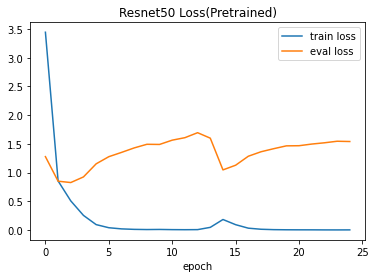

In [64]:
plt.plot(np.arange(len(resnet50_train_losses)), resnet50_train_losses,label="train loss")
plt.plot(np.arange(len(resnet50_eval_losses)), resnet50_eval_losses, label="eval loss")
plt.legend() #显示图例
plt.xlabel('epoch')
plt.title('Resnet50 Loss(Pretrained)')
plt.savefig("./Resnet50_Loss(Pretrained).jpg")

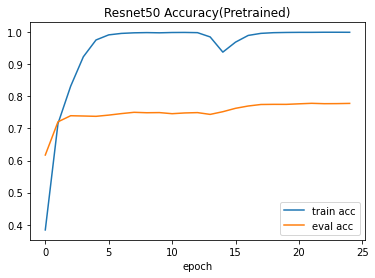

In [63]:
plt.plot(np.arange(len(resnet50_train_acces)), resnet50_train_acces, label="train acc")
plt.plot(np.arange(len(resnet50_eval_acces)), resnet50_eval_acces, label="eval acc")
plt.legend() #显示图例
plt.xlabel('epoch')
plt.title('Resnet50 Accuracy(Pretrained)')
plt.savefig("./Resnet50_Accuracy(Pretrained).jpg")

## 3. 知识蒸馏

教师模型：resnet50_pretrain with 25 epoch 1e-4 lr

学生模型：resnet18_scratch

**结果对比:**

- resnet18 from scratch (epoch=25, lr=1e-4): 54.56%

- resnet50 with pretrain (epoch=25, lr=1e-4): 78.57%

- resnet18 with pretrained resnet50 distillation (epoch=25, lr=1e-3): 70.74%

In [47]:
import torch.nn.functional as F
soft_loss = torch.nn.KLDivLoss(reduction="batchmean")
hard_loss = nn.CrossEntropyLoss()
EPOCH = 25              # 训练epoch次数
BATCH_SIZE = 1024         # 批训练的数量

distill_resnet18_train_losses = []
distill_resnet18_train_acces = []
distill_resnet18_eval_losses = []
distill_resnet18_eval_acces = []


teacher_model = torch.load('cifar10_resnet50_pretrain.pt') #加载模型
teacher_model.eval() #切换到测试模式

student_model = torchvision.models.resnet18(pretrained=False)
# MNIST数据集下载
train_data = datasets.CIFAR10(root='./data',
                         train=True,                         # 训练集
                         transform=transforms.ToTensor(),    # 转换为Tensor并归一化[0~1]
                         download=False
                        )

test_data = datasets.CIFAR10(root='./data',
                        train=False,                         # 测试集
                        transform=transforms.ToTensor(),     # 转换为Tensor并归一化[0~1]
                        download=False
                        )
# Cifar-10的标签
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 使用DataLoader进行分批  dataset: 传入的数据集 batch_size: 每个batch有多少个样本  shuffle: 在每个epoch开始的时候，对数据进行重新排序
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

#损失函数:这里用交叉熵 = log_softmax和nll_loss的结合
alpha = 0.3
temp = 7
Total_acc = 0.0

#优化器 这里用SGD
optimizer = optim.Adam(student_model.parameters(), lr=1e-3)

#device : GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model.to(device) #将模型加载到相应设备中


for epoch in range(EPOCH):
    start_time = time.time() #记录当前时间
    train_loss = 0
    train_acc = 0
    student_model.train()

    for i, data in enumerate(train_loader, start=0):
        # data里面包含图像数据（inputs）(tensor类型的）和标签（labels）(tensor类型）。
        inputs, labels = data
        # 将数据加载到相应设备中
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            teacher_outputs = teacher_model(inputs)

        # 前向传播
        student_outputs = student_model(inputs)
        # 计算损失函数
        student_loss = hard_loss(student_outputs, labels)

        distillation_loss = F.kl_div(F.log_softmax(student_outputs / temp, dim=1), F.softmax(teacher_outputs / temp, dim=1), reduction='batchmean') * temp * temp

        loss = alpha * student_loss + (1-alpha) * distillation_loss

        # 清空上一轮梯度
        optimizer.zero_grad()
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()

        train_loss += loss.item()

        _, predicted = torch.max(student_outputs.data, 1)
        total += labels.size(0)
        num_correct = (predicted == labels).sum().item()
        acc = num_correct / inputs.shape[0]
        train_acc += acc


    distill_resnet18_train_losses.append(train_loss / len(train_loader))
    distill_resnet18_train_acces.append(train_acc / len(train_loader))

    student_model.eval() #切换到测试模式
    eval_loss = 0
    eval_acc = 0

    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # 前向传播
        out = student_model(images)
        loss = hard_loss(out, labels)
        eval_loss += loss.item()
        # 求出预测值索引  torch.max(input, dim) dim=1，行最大值
        _, predicted = torch.max(out.data, 1)
        num_correct = (predicted == labels).sum().item()
        acc = num_correct / images.shape[0]
        eval_acc += acc
    
    
    distill_resnet18_eval_losses.append(eval_loss/len(test_loader))
    distill_resnet18_eval_acces.append((eval_acc/len(test_loader)))
    #保存训练模型
    if eval_acc > Total_acc:
        torch.save(student_model, 'distill_resnet18.pt')
        print("saved best model")
        Total_acc = eval_acc

    print('epoch: {} \nTrain Loss: {:.4f} \nEval Loss: {:.4f} \nTrain Acc: {:.4f} \nEval Acc: {:.4f}'
          .format(epoch, 
                  train_loss / len(train_loader), 
                  eval_loss / len(test_loader), 
                  train_acc / len(train_loader),
                  eval_acc / len(test_loader)))



/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


saved best model
epoch: 0 
Train Loss: 3.2925 
Eval Loss: 4.5967 
Train Acc: 0.4671 
Eval Acc: 0.2751
saved best model
epoch: 1 
Train Loss: 2.3022 
Eval Loss: 2.0372 
Train Acc: 0.6197 
Eval Acc: 0.5775
epoch: 2 
Train Loss: 1.9292 
Eval Loss: 2.4317 
Train Acc: 0.6976 
Eval Acc: 0.5540
saved best model
epoch: 3 
Train Loss: 1.7229 
Eval Loss: 1.9945 
Train Acc: 0.7386 
Eval Acc: 0.6103
epoch: 4 
Train Loss: 1.5761 
Eval Loss: 4.6551 
Train Acc: 0.7704 
Eval Acc: 0.4472
saved best model
epoch: 5 
Train Loss: 1.4800 
Eval Loss: 2.0003 
Train Acc: 0.7909 
Eval Acc: 0.6461
epoch: 6 
Train Loss: 1.3826 
Eval Loss: 2.0628 
Train Acc: 0.8116 
Eval Acc: 0.6454
epoch: 7 
Train Loss: 1.2485 
Eval Loss: 2.6974 
Train Acc: 0.8444 
Eval Acc: 0.5963
epoch: 8 
Train Loss: 1.1755 
Eval Loss: 3.1841 
Train Acc: 0.8599 
Eval Acc: 0.5759
epoch: 9 
Train Loss: 1.1062 
Eval Loss: 3.3090 
Train Acc: 0.8792 
Eval Acc: 0.5791
epoch: 10 
Train Loss: 1.0281 
Eval Loss: 3.3855 
Train Acc: 0.8979 
Eval Acc: 0.5

#### 测试模型

In [49]:
# 测试
model = torch.load('distill_resnet18.pt') #加载模型
model.eval() #切换到测试模式

correct = 0
total = 0

for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    # 前向传播
    out = model(images)
    # 求出预测值索引  torch.max(input, dim) dim=1，行最大值
    _, predicted = torch.max(out.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

#输出识别准确率
print('10000测试图像 准确率:{:.4f}%'.format(100 * correct / total))

10000测试图像 准确率:70.7400%


#### 绘图

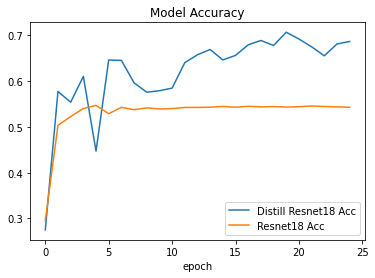

In [62]:
plt.plot(np.arange(len(distill_resnet18_eval_acces)), distill_resnet18_eval_acces, label="Distill Resnet18 Acc")
plt.plot(np.arange(len(resnet18_eval_acces)), resnet18_eval_acces, label="Resnet18 Acc")
plt.legend() #显示图例
plt.xlabel('epoch')
plt.title('Model Accuracy')
plt.savefig("./Distill_Resnet18_Accuracy(Pretrained).jpg")

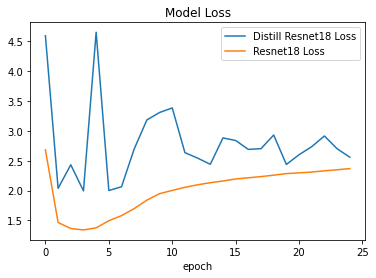

In [61]:
plt.plot(np.arange(len(distill_resnet18_eval_losses)), distill_resnet18_eval_losses, label="Distill Resnet18 Loss")
plt.plot(np.arange(len(resnet18_eval_losses)), resnet18_eval_losses, label="Resnet18 Loss")
plt.legend() #显示图例
plt.xlabel('epoch')
plt.title('Model Loss')
plt.savefig("./Distill_Resnet18_loss(Pretrained).jpg")